# Projeto 2 - Previsão de renda

###  Alcides Gabriel


### 4 elementos importantes
- Esse notebook
- Streamlit com as análises
- Seu Github com o projeto
- Vídeo no readme do github mostrando o streamlit

## Etapa 1 CRISP - DM: Entendimento do negócio

- Uma das técnicas mais utilizadas na área de machine learning é a regressão, essa técnicas consiste em modelos matemáticos que irão aprender com os dados de entrada e retornar valores numéricos, continuos ou discretos, assim abrindo uma gama de oportunidades de aplicações. Então nada como um modelo difícil, como uma previsão de renda, para por a teste os modelos ensinados e treinados ao longo do curso.


## Etapa 2 Crisp-DM: Entendimento dos dados

- Os dados aparentam pertencer originalmente ao dataset associado a bons e maus pagadores, assim permitindo a liberação de crédito, porém o foco aqui é a previsão da renda de cada cliente com base em outros atributos.


### Dicionário de dados


| Variável                | Descrição                                           | Tipo         |
| ----------------------- |:---------------------------------------------------:| ------------:|
| data_ref                |  Data de referência                                 | Datatime     |
| id_cliente              |  Identificador                                      | Int|
| sexo                    |  Sexo                                     | Object|
| posse_de_veiculo        |  Se tem veículo                                    | Booleano|
| posse_de_imovel         |  Se tem imóvel próprio                                      | Booleano|
| qtd_filhos              |  Número de filhos                                   | Int|
| tipo_renda              |  Tipo de renda                                      | Object|
| educacao                |  Nível Escolar                                      | Object|
| estado_civil            |  Estado civil                                      | Object|
| tipo_residencia         |  Tipo de residencia                                      | Object|
| idade                   |  idade                                      |Int|
| tempo_emprego           |  Tempo de emprego                                      | Float|
| qt_pessoas_residencia   |  Pessoas por casa                                      | Float|
| renda                   |  Valor da renda                                      | Float|





#### Carregando os pacotes
É considerado uma boa prática carregar os pacotes que serão utilizados como a primeira coisa do programa.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from ydata_profiling import ProfileReport
from IPython.display import clear_output

%matplotlib inline

import patsy
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import cross_val_score

#### Carregando os dados
O comando pd.read_csv é um comando da biblioteca pandas (pd.) e carrega os dados do arquivo csv indicado para um objeto *dataframe* do pandas.

In [2]:
renda = pd.read_csv('./previsao_de_renda.csv')

In [3]:
renda.head(10)

renda = renda.drop("Unnamed: 0", axis=1)
ID = renda.pop('id_cliente')
renda.head()

,data_ref,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda
0,2015-01-01,F,False,True,0,Empresário,Secundário,Solteiro,Casa,26,6.602740,1.0,8060.34
1,2015-01-01,M,True,True,0,Assalariado,Superior completo,Casado,Casa,28,7.183562,2.0,1852.15
2,2015-01-01,F,True,True,0,Empresário,Superior completo,Casado,Casa,35,0.838356,2.0,2253.89
3,2015-01-01,F,False,True,1,Servidor público,Superior completo,Casado,Casa,30,4.846575,3.0,6600.77
4,2015-01-01,M,True,False,0,Assalariado,Secundário,Solteiro,Governamental,33,4.293151,1.0,6475.97


#### Entendimento dos dados - Univariada
Nesta etapa tipicamente avaliamos a distribuição de todas as variáveis. 

In [4]:
prof = ProfileReport(df= renda, minimal=True, explorative=True)
prof

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [5]:
prof.to_file('./output/renda_analisys.html')

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

### Entendimento dos dados - Bivariadas




### Análise de distribuição

#### Categórico
- Para realizar a análise de distribuição dos dados em relação a renda, o atributo alvo (renda) será separado pelos quartis, permitindo assim averiguar o comportamento das classes em relação ao alvo e quanto as classes se diferente entre si.

#### Numérico
- Para os dados numéricos, será feita somente um gráfico de dispersão comum.

In [6]:
### Gráfico de categóricos - alvo
def renda_analise(data, alvo) -> None:
    """
    ----- Entrada ------
    data -> DataFrame contendo os atributos independentes
    alvo -> Series contendo o atributo dependente.
    
    ----- Objetivo -------
    Gerar um gráfico que permite avaliar a distribuição de cada atributo para a criação de novos atributos preditores.
    
    ----- Funcionamento -------
    1. Seleção de atributos
        Com base no exercício anterior
        
    2. Binning
        Cortar um dado numérico em quartís, garantindo a proporção de 4 pedaços iguais, isso irá ajudar na análise 
        de distribuição 
        
    3. Gráfico
        3.1. Gráfico de caixa
        3.2. Gráfico de barra
    """
    
    
    # 1. Seleção de atributos
    dt = data.copy()
    renda = dt[alvo]
    dt = pd.concat([dt.loc[:,['qt_pessoas_residencia','qtd_filhos']].astype(str), dt.select_dtypes(exclude=np.number)], axis=1)

    # 2. Binning
    dt['renda_quartil'] = pd.qcut(renda, q=4).astype(str)
    
    
    # 3. Gráfico
    figura = plt.figure(figsize=(15,70)) # Tamanho
    figura.suptitle('Análise das variáveis em relação à renda', fontsize=29) # Título
    figura.subplots_adjust(top=0.95, # Espaço entre o título e os gráficos
                            hspace = 0.5) # Distância entre gráficos.
    tamanho = (11,1) # Tamanho
    atributos = dt.columns[:-1]
    
    
    # 3.1. Gráfico de caixa
    for i in range(9): 
        
        pos = (i,0) # Posição na figura
        ax = plt.subplot2grid(tamanho, pos) # axis
        
        sns.boxplot(y=dt[atributos[i]], x=renda, orient='h',ax = ax, width=.5) # plot
        
    ## 
    dt = data.copy()
    dt.loc[:,['qt_pessoas_residencia','qtd_filhos']] = dt.loc[:,['qt_pessoas_residencia','qtd_filhos']].astype(str)
    dt = dt.select_dtypes(include=np.number)
    dt['renda'] = renda
    
    
    for i in range(2): 
        
        pos = (i + 9,0) # Posição na figura
        ax = plt.subplot2grid(tamanho, pos) # axis
        
        sns.regplot(x=dt.iloc[:,i], y=renda, ax = ax,line_kws={"color": "red"}) # plot    
    
    
    
    return plt.show()

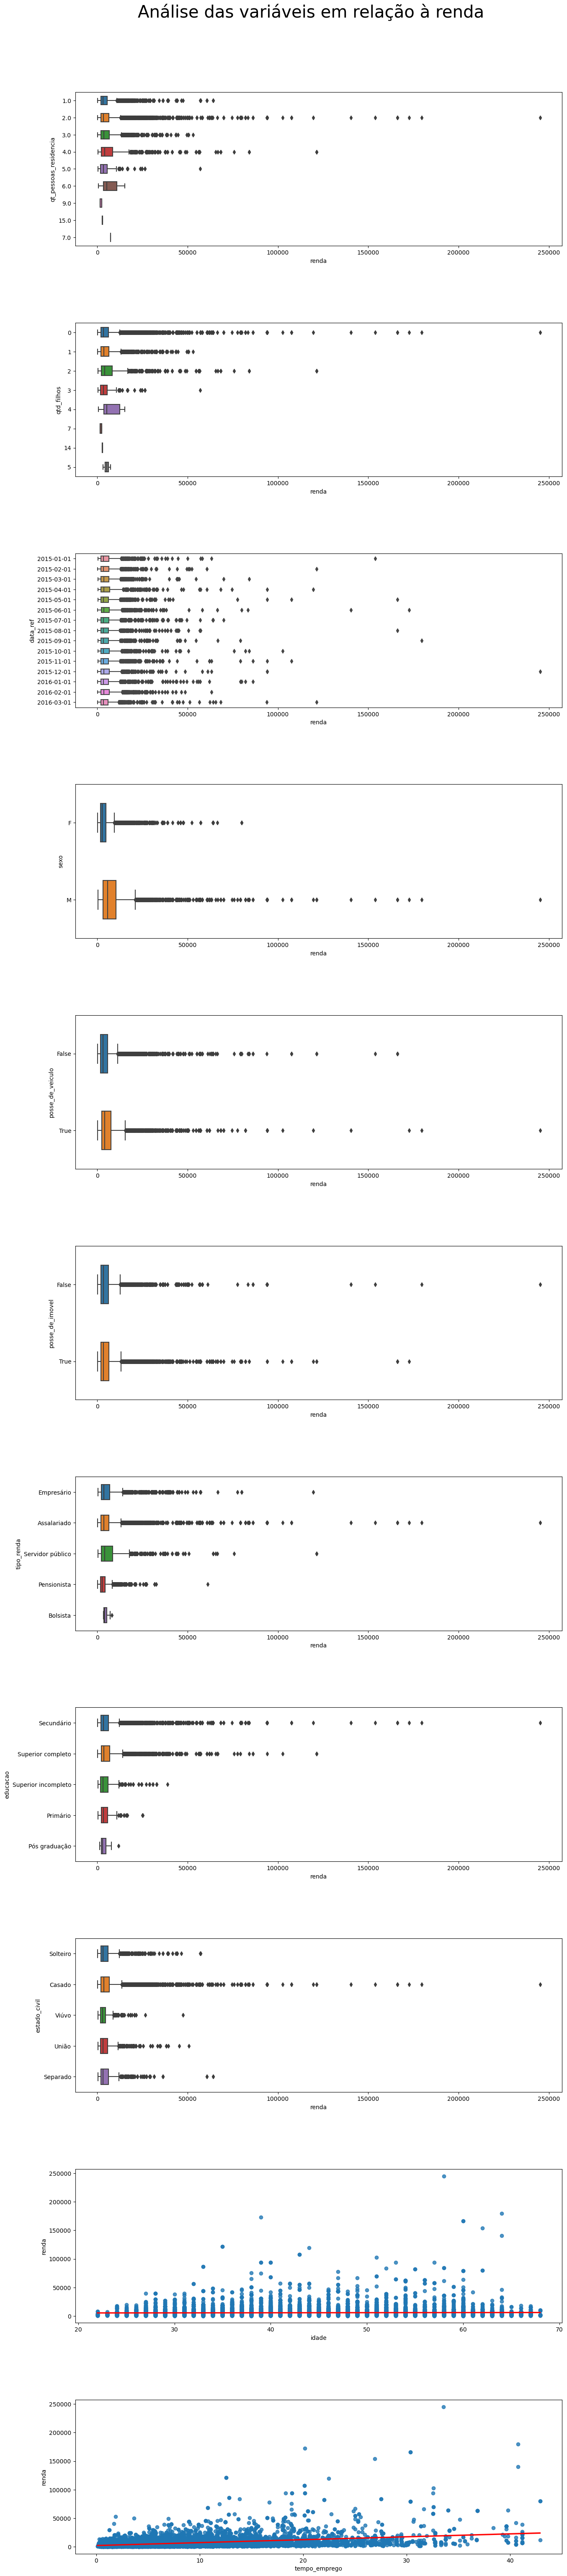

In [7]:
renda_analise(renda, 'renda')

## Etapa 3 Crisp-DM: Preparação dos dados
Nessa etapa realizamos tipicamente as seguintes operações com os dados:

 - **seleção**: Já temos os dados selecionados adequadamente?
 - **limpeza**: Precisaremos identificar e tratar dados faltantes
 - **construção**: construção de novas variáveis
 - **integração**: Temos apenas uma fonte de dados, não é necessário integração
 - **formatação**: Os dados já se encontram em formatos úteis?



A etapa da análise univariada permitiu esclarecer alguns pontos sobre o tratamendo de dados necessários, sendo eles os seguintes itens abaixo.

- O atributo tempo de emprego deve ser estudado para tomar a decisão se deve ou não ser elimiado os dados faltantes, pois pode ser uma informação de desemprego ou alguma outra relação com essa variável.
- Dois atributos numéricos apresentam uma distribuição muito curta, que se considerados valores categóricos podem ser melhor aproveitados e usados no modelo de análise, sendo-os quantidade de filhos e quantidade de pessoas na residência.
- As informações sobre curtose e assimatria da variável alvo (renda), demostra que sua distribuição é do tipo exponencial, sendo assim um tratamento que melhora o resultado é transformar esse para aproximar de uma distribuição normal, usando um método como o log.

Com base na análise bivariada, observa-se que algumas classes de categorias aparentam não terem diferença estatística significativa entre elas, mas para um resultado preciso será realizado a frente um estudo para confirmação do que pode-se aproveitar.

In [8]:
# Averiguar dados faltantes em tempo de emprego.
print(renda.loc[renda['tempo_emprego'].isnull(),'tipo_renda'].unique())

# É possível reparar que são dados de pessoas aposentadas, onde o tempo de emprego acaba sendo uma informação não relevante.
# Pois podem ser pessoas aposentadas por outros motivos, não somente por tempo de serviço.
# Então preencher essa variável com ZERO pode ser uma possibilidade interessante para não perder informação de 2573 clientes.
renda.loc[:,'tempo_emprego'] = renda['tempo_emprego'].fillna(0)

['Pensionista']


In [9]:
renda.isnull().sum()

data_ref                 0
sexo                     0
posse_de_veiculo         0
posse_de_imovel          0
qtd_filhos               0
tipo_renda               0
educacao                 0
estado_civil             0
tipo_residencia          0
idade                    0
tempo_emprego            0
qt_pessoas_residencia    0
renda                    0
dtype: int64

In [10]:
# Passar para o formato de string as variáveis quantidade de filhos e de pessoas por residência
renda.loc[:,['qtd_filhos','qt_pessoas_residencia']] = renda.loc[:,['qtd_filhos','qt_pessoas_residencia']].astype(str)

In [11]:
renda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   data_ref               15000 non-null  object 
 1   sexo                   15000 non-null  object 
 2   posse_de_veiculo       15000 non-null  bool   
 3   posse_de_imovel        15000 non-null  bool   
 4   qtd_filhos             15000 non-null  object 
 5   tipo_renda             15000 non-null  object 
 6   educacao               15000 non-null  object 
 7   estado_civil           15000 non-null  object 
 8   tipo_residencia        15000 non-null  object 
 9   idade                  15000 non-null  int64  
 10  tempo_emprego          15000 non-null  float64
 11  qt_pessoas_residencia  15000 non-null  object 
 12  renda                  15000 non-null  float64
dtypes: bool(2), float64(2), int64(1), object(8)
memory usage: 1.3+ MB


In [12]:
# Observando a informação acima é possível ver que a posse de veículo e imóvel é um booleano
# e isso pode causar problemas para o uso desses dados, sendo melhor passa-los para o formato de string.
renda.loc[:,['posse_de_veiculo','posse_de_imovel']] = renda.loc[:,['posse_de_veiculo','posse_de_imovel']].astype(str)

<Axes: ylabel='Frequency'>

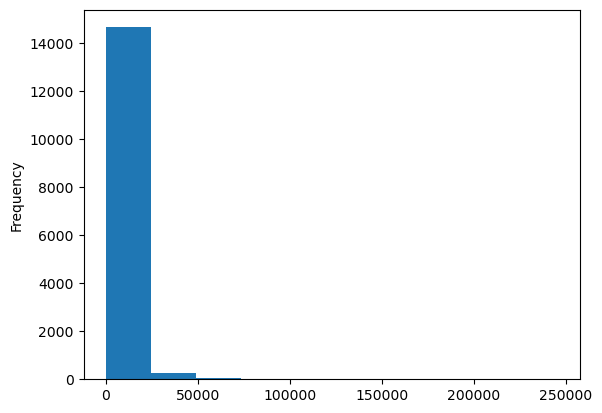

In [13]:
# Transformação do atributo renda.
renda['renda'].plot(kind='hist')

<Axes: ylabel='Frequency'>

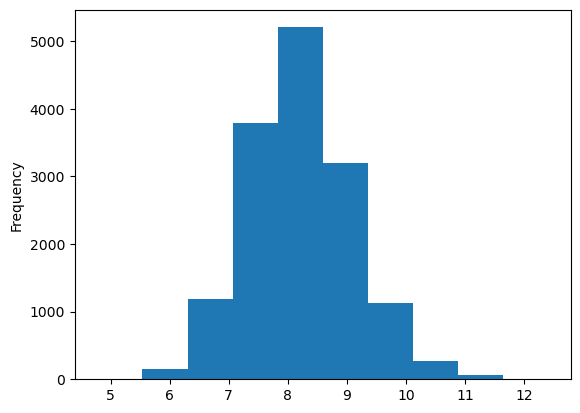

In [14]:
np.log(renda['renda']).plot(kind='hist')

In [15]:
renda.loc[:,'renda'] = np.log(renda['renda'])

In [16]:
renda.head(10)

,data_ref,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda
0,2015-01-01,F,False,True,0,Empresário,Secundário,Solteiro,Casa,26,6.602740,1.0,8.994711
1,2015-01-01,M,True,True,0,Assalariado,Superior completo,Casado,Casa,28,7.183562,2.0,7.524102
2,2015-01-01,F,True,True,0,Empresário,Superior completo,Casado,Casa,35,0.838356,2.0,7.720413
3,2015-01-01,F,False,True,1,Servidor público,Superior completo,Casado,Casa,30,4.846575,3.0,8.794942
4,2015-01-01,M,True,False,0,Assalariado,Secundário,Solteiro,Governamental,33,4.293151,1.0,8.775854
5,2015-01-01,F,False,True,0,Assalariado,Superior completo,Casado,Casa,39,4.345205,2.0,7.276466
6,2015-01-01,F,False,True,0,Empresário,Superior completo,Viúvo,Casa,55,6.378082,1.0,7.453579
7,2015-01-01,F,False,True,0,Empresário,Secundário,Casado,Casa,36,3.104110,2.0,7.830418
8,2015-01-01,F,False,True,0,Assalariado,Secundário,Casado,Casa,50,18.605479,2.0,8.137495
9,2015-01-01,M,True,True,0,Assalariado,Superior completo,Casado,Casa,60,10.558904,2.0,9.468012


## Etapa 4 Crisp-DM: Modelagem
Nessa etapa que realizaremos a construção do modelo. Os passos típicos são:
- Selecionar a técnica de modelagem
- Desenho do teste
- Avaliação do modelo


### Rodando o modelo


O modelo será dividido em 2 etapas diferentes. 
- A primeira será uma avaliação inicial usando regressões lineares, o intuito aqui será aplicar 3 tipos de modelos:
    - O primeiro será uma regressão linear simples
    - O segundo um regressão Lasso
    - O terceiro será uma regressão filtrando com base no P-value.
    
    
- A segunda etapa consiste em utilizar métodos com base em árvore de decisão, sendo-os 
    - Árvore de decisão
    - Random Forest
    - Gradient Boosting.
    - Ada Boost


#### Modelagem Linear

In [17]:
def modelo_linear():
    numericas = 'idade + tempo_emprego '
    categoricas = ' + '.join([f'C({i})' for i in renda.select_dtypes(exclude=np.number)]) 
    entrada = f'renda ~ {numericas} + {categoricas}'
    y, X = patsy.dmatrices(entrada, renda)
    
    modelo = sm.OLS(y,X).fit()
    
    
    tabela = pd.DataFrame(modelo.summary().tables[1])
    colunas = tabela.loc[0,:].astype(str).tolist()
    colunas[0] = 'atributos'
    tabela.columns = colunas
    tabela = tabela.drop(0, axis=0)
    tabela.iloc[:,0] = tabela.iloc[:,0].astype(str)
    
    for i in colunas[1:]:
        tabela[i] =  tabela[i].astype(str).astype(float)
        
        
    return modelo.summary(), tabela
    
sumario, tabela = modelo_linear()

In [18]:
sumario

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  renda   R-squared:                       0.350
Model:                            OLS   Adj. R-squared:                  0.348
Method:                 Least Squares   F-statistic:                     167.6
Date:                Mon, 13 Nov 2023   Prob (F-statistic):               0.00
Time:                        10:19:05   Log-Likelihood:                -16196.
No. Observations:               15000   AIC:                         3.249e+04
Df Residuals:                   14951   BIC:                         3.286e+04
Df Model:                          48                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                               6.9506      0.136     51.192      0.000       6.684       7.217
C(data_ref)[T.2015-02-01]              -0.0045      0.032     -0.142      0.887      -0.067       0.058
C(data_ref)[T.2015-03-01]               0.0410      0.032      1.285      0.199      -0.022       0.104
C(data_ref)[T.2015-04-01]               0.0211      0.032      0.661      0.508      -0.041       0.084
C(data_ref)[T.2015-05-01]              -0.0261      0.032     -0.817      0.414      -0.089       0.037
C(data_ref)[T.2015-06-01]               0.0520      0.032      1.629      0.103      -0.011       0.115
C(data_ref)[T.2015-07-01]               0.0132      0.032      0.414      0.679      -0.049       0.076
C(data_ref)[T.2015-08-01]              -0.0049      0.032     -0.152      0.879      -0.067       0.058
C(data_ref)[T.2015-09-01]              -0.0146      0.032     -0.455      0.649      -0.077       0.048
C(data_ref)[T.2015-10-01]               0.0035      0.032      0.109      0.913      -0.059       0.066
C(data_ref)[T.2015-11-01]               0.0027      0.032      0.084      0.933      -0.060       0.065
C(data_ref)[T.2015-12-01]               0.0367      0.032      1.146      0.252      -0.026       0.099
C(data_ref)[T.2016-01-01]              -0.0349      0.032     -1.091      0.275      -0.098       0.028
C(data_ref)[T.2016-02-01]              -0.0168      0.032     -0.526      0.599      -0.080       0.046
C(data_ref)[T.2016-03-01]              -0.0504      0.032     -1.578      0.115      -0.113       0.012
C(sexo)[T.M]                            0.7952      0.014     57.650      0.000       0.768       0.822
C(posse_de_veiculo)[T.True]             0.0340      0.013      2.608      0.009       0.008       0.060
C(posse_de_imovel)[T.True]              0.0906      0.013      7.039      0.000       0.065       0.116
C(qtd_filhos)[T.1]                     -0.2076      0.108     -1.918      0.055      -0.420       0.005
C(qtd_filhos)[T.14]                    -0.3224      0.253     -1.275      0.202      -0.818       0.173
C(qtd_filhos)[T.2]                     -0.5024      0.216     -2.326      0.020      -0.926      -0.079
C(qtd_filhos)[T.3]                     -0.4205      0.430     -0.978      0.328      -1.263       0.422
C(qtd_filhos)[T.4]                      0.3102      0.434      0.716      0.474      -0.540       1.160
C(qtd_filhos)[T.5]                      0.2929      0.402      0.728      0.467      -0.496       1.081
C(qtd_filhos)[T.7]                      0.1490      0.168      0.884      0.377      -0.181       0.479
C(tipo_renda)[T.Bolsista]               0.2069      0.238      0.867      0.386      -0.261       0.674
C(tipo_renda)[T.Empresário]             0.1549      0.015     10.49

In [19]:
def modelo_linear():
    numericas = 'idade + tempo_emprego '
    categoricas = ' + '.join([f'C({i})' for i in renda.select_dtypes(exclude=np.number)]) 
    entrada = f'renda ~ {numericas} + {categoricas}'
    y, X = patsy.dmatrices(entrada, renda)
    
    modelo = sm.OLS(y,X).fit_regularized(method='elastic_net', refit=True, L1_wt = 1, alpha = 0)
    
    
    tabela = pd.DataFrame(modelo.summary().tables[1])
    colunas = tabela.loc[0,:].astype(str).tolist()
    colunas[0] = 'atributos'
    tabela.columns = colunas
    tabela = tabela.drop(0, axis=0)
    tabela.iloc[:,0] = tabela.iloc[:,0].astype(str)
    
    for i in colunas[1:]:
        tabela[i] =  tabela[i].astype(str).astype(float)
        
        
    return modelo.summary(), tabela
    
sumario, tabela = modelo_linear()

C:\Users\alcid\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1965: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(eigvals[0]/eigvals[-1])


In [20]:
sumario

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  renda   R-squared:                       0.350
Model:                            OLS   Adj. R-squared:                  0.348
Method:                 Least Squares   F-statistic:                     154.7
Date:                Mon, 13 Nov 2023   Prob (F-statistic):               0.00
Time:                        10:19:09   Log-Likelihood:                -16196.
No. Observations:               15000   AIC:                         3.250e+04
Df Residuals:                   14948   BIC:                         3.290e+04
Df Model:                          52                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                               6.9506      0.136     51.187      0.000       6.684       7.217
C(data_ref)[T.2015-02-01]              -0.0045      0.032     -0.142      0.887      -0.067       0.058
C(data_ref)[T.2015-03-01]               0.0410      0.032      1.284      0.199      -0.022       0.104
C(data_ref)[T.2015-04-01]               0.0211      0.032      0.661      0.508      -0.042       0.084
C(data_ref)[T.2015-05-01]              -0.0261      0.032     -0.817      0.414      -0.089       0.037
C(data_ref)[T.2015-06-01]               0.0520      0.032      1.629      0.103      -0.011       0.115
C(data_ref)[T.2015-07-01]               0.0132      0.032      0.414      0.679      -0.049       0.076
C(data_ref)[T.2015-08-01]              -0.0049      0.032     -0.152      0.879      -0.067       0.058
C(data_ref)[T.2015-09-01]              -0.0146      0.032     -0.455      0.649      -0.077       0.048
C(data_ref)[T.2015-10-01]               0.0035      0.032      0.109      0.913      -0.059       0.066
C(data_ref)[T.2015-11-01]               0.0027      0.032      0.084      0.933      -0.060       0.065
C(data_ref)[T.2015-12-01]               0.0367      0.032      1.146      0.252      -0.026       0.099
C(data_ref)[T.2016-01-01]              -0.0349      0.032     -1.091      0.275      -0.098       0.028
C(data_ref)[T.2016-02-01]              -0.0168      0.032     -0.526      0.599      -0.080       0.046
C(data_ref)[T.2016-03-01]              -0.0504      0.032     -1.578      0.115      -0.113       0.012
C(sexo)[T.M]                            0.7952      0.014     57.645      0.000       0.768       0.822
C(posse_de_veiculo)[T.True]             0.0340      0.013      2.608      0.009       0.008       0.060
C(posse_de_imovel)[T.True]              0.0906      0.013      7.039      0.000       0.065       0.116
C(qtd_filhos)[T.1]                     -0.2076      0.108     -1.918      0.055      -0.420       0.005
C(qtd_filhos)[T.14]                    -0.3224      0.253     -1.275      0.202      -0.818       0.173
C(qtd_filhos)[T.2]                     -0.5024      0.216     -2.326      0.020      -0.926      -0.079
C(qtd_filhos)[T.3]                     -0.4205      0.430     -0.978      0.328      -1.263       0.422
C(qtd_filhos)[T.4]                      0.3102      0.434      0.715      0.474      -0.540       1.160
C(qtd_filhos)[T.5]                      0.2929      0.402      0.728      0.467      -0.496       1.081
C(qtd_filhos)[T.7]                      0.1490      0.168      0.884      0.377      -0.181       0.479
C(tipo_renda)[T.Bolsista]               0.2069      0.238      0.867      0.386      -0.261       0.674
C(tipo_renda)[T.Empresário]             0.1549      0.015     10.49

In [21]:
def modificar_reg_lin(tab):
    dt = renda.copy()
    modificar = []
    remover = []
    tabela = tab.copy()
    for i in renda.select_dtypes(exclude=np.number):

        tabela_1 = tabela[tabela['atributos'].str.contains(i)].sort_values(by='P>|t|').loc[:,['atributos','P>|t|']]
        tabela_1 = tabela_1.loc[tabela_1['P>|t|'] < 0.05]
        modificar = [ii.replace(f'C({i})','').replace('T.','').replace('[','').replace(']','') for ii in tabela_1['atributos']]
        if len(modificar) == 0:
            remover.append(i)
            continue
        dt.loc[~dt[i].isin(modificar), i] = 'outros'

    dt = dt.drop(remover,axis=1)
    
    numericas = 'idade + tempo_emprego '
    categoricas = ' + '.join([f'C({i})' for i in dt.select_dtypes(exclude=np.number)]) 
    entrada = f'renda ~ {numericas} + {categoricas}'
    y, X = patsy.dmatrices(entrada, dt)
    
    modelo = sm.OLS(y,X).fit()
    
    
    tabela = pd.DataFrame(modelo.summary().tables[1])
    colunas = tabela.loc[0,:].astype(str).tolist()
    colunas[0] = 'atributos'
    tabela.columns = colunas
    tabela = tabela.drop(0, axis=0)
    tabela.iloc[:,0] = tabela.iloc[:,0].astype(str)
    
    for i in colunas[1:]:
        tabela[i] =  tabela[i].astype(str).astype(float)
        
        
    return modelo.summary()


modificar_reg_lin(tabela)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  renda   R-squared:                       0.344
Model:                            OLS   Adj. R-squared:                  0.343
Method:                 Least Squares   F-statistic:                     523.7
Date:                Mon, 13 Nov 2023   Prob (F-statistic):               0.00
Time:                        10:19:10   Log-Likelihood:                -16264.
No. Observations:               15000   AIC:                         3.256e+04
Df Residuals:                   14984   BIC:                         3.268e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Intercept                              8.1657      0.092     89.071      0.000       7.986       8.345
C(sexo)[T.outros]                     -0.7881      0.014    -57.264      0.000      -0.815      -0.761
C(posse_de_veiculo)[T.outros]         -0.0451      0.013     -3.470      0.001      -0.071      -0.020
C(posse_de_imovel)[T.outros]          -0.0910      0.013     -7.186      0.000      -0.116      -0.066
C(qtd_filhos)[T.outros]                0.1416      0.085      1.664      0.096      -0.025       0.309
C(tipo_renda)[T.Pensionista]           0.1171      0.025      4.640      0.000       0.068       0.167
C(tipo_renda)[T.Servidor público]     -0.0878      0.024     -3.685      0.000      -0.134      -0.041
C(tipo_renda)[T.outros]               -0.1631      0.015    -11.090      0.000      -0.192      -0.134
C(estado_civil)[T.Solteiro]           -0.0458      0.030     -1.530      0.126      -0.104       0.013
C(estado_civil)[T.Viúvo]              -0.0067      0.037     -0.180      0.857      -0.080       0.066
C(estado_civil)[T.outros]             -0.0744      0.032     -2.329      0.020      -0.137      -0.012
C(qt_pessoas_residencia)[T.3.0]        0.0392      0.017      2.248      0.025       0.005       0.073
C(qt_pessoas_residencia)[T.4.0]        0.2280      0.088      2.589      0.010       0.055       0.401
C(qt_pessoas_residencia)[T.outros]    -0.0465      0.028     -1.678      0.093      -0.101       0.008
idade                                  0.0051      0.001      6.832      0.000       0.004       0.007
tempo_emprego                          0.0616      0.001     60.178      0.000       0.060       0.064
==============================================================================
Omnibus:                        1.587   Durbin-Watson:                   2.019
Prob(Omnibus):                  0.452   Jarque-Bera (JB):                1.565
Skew:                           0.015   Prob(JB):                        0.457
Kurtosis:                       3.040   Cond. No.                     1.16e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.16e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Modelagem Árvore

In [22]:
def arvore_dec():
    dt = renda.copy()
    for atr in dt.select_dtypes(exclude=np.number):
        dt.loc[:, atr] = LabelEncoder().fit_transform(dt[atr])
    
    y = dt.pop('renda')
    model = DecisionTreeRegressor()
    resultado = cross_val_score(estimator=model, y=y, X=dt, scoring='r2', cv=10).mean()
    saida = f'O valor de r2 para o modelo treinado é de {round(resultado*100,3) } %'
    return saida
arvore_dec()

'O valor de r2 para o modelo treinado é de -1.747 %'

In [23]:
def arvore_dec():
    dt = renda.copy()
    for atr in dt.select_dtypes(exclude=np.number):
        dt.loc[:, atr] = LabelEncoder().fit_transform(dt[atr])
    
    y = dt.pop('renda')
    model = RandomForestRegressor()
    resultado = cross_val_score(estimator=model, y=y, X=dt, scoring='r2', cv=10).mean()
    saida = f'O valor de r2 para o modelo treinado é de {round(resultado*100,3) } %'
    return saida

arvore_dec()

'O valor de r2 para o modelo treinado é de 38.622 %'

In [24]:
def arvore_dec():
    dt = renda.copy()
    for atr in dt.select_dtypes(exclude=np.number):
        dt.loc[:, atr] = LabelEncoder().fit_transform(dt[atr])
    
    y = dt.pop('renda')
    model = GradientBoostingRegressor()
    resultado = cross_val_score(estimator=model, y=y, X=dt, scoring='r2', cv=10).mean()
    saida = f'O valor de r2 para o modelo treinado é de {round(resultado*100,3) } %'
    return saida
arvore_dec()

'O valor de r2 para o modelo treinado é de 37.464 %'

In [25]:
def arvore_dec():
    dt = renda.copy()
    for atr in dt.select_dtypes(exclude=np.number):
        dt.loc[:, atr] = LabelEncoder().fit_transform(dt[atr])
    
    y = dt.pop('renda')
    model = AdaBoostRegressor()
    resultado = cross_val_score(estimator=model, y=y, X=dt, scoring='r2', cv=10).mean()
    saida = f'O valor de r2 para o modelo treinado é de {round(resultado*100,3) } %'
    return saida

arvore_dec()

'O valor de r2 para o modelo treinado é de 34.388 %'

In [26]:
def teste_model(tab):
    dt = renda.copy()
    modificar = []
    remover = []
    tabela = tab.copy()
    for i in renda.select_dtypes(exclude=np.number):

        tabela_1 = tabela[tabela['atributos'].str.contains(i)].sort_values(by='P>|t|').loc[:,['atributos','P>|t|']]
        tabela_1 = tabela_1.loc[tabela_1['P>|t|'] < 0.05]
        modificar = [ii.replace(f'C({i})','').replace('T.','').replace('[','').replace(']','') for ii in tabela_1['atributos']]
        if len(modificar) == 0:
            remover.append(i)
            continue
        dt.loc[~dt[i].isin(modificar), i] = 'outros'

    dt = dt.drop(remover,axis=1)
    for atr in dt.select_dtypes(exclude=np.number):
        dt.loc[:, atr] = LabelEncoder().fit_transform(dt[atr])
    
    y = dt.pop('renda')
    model = RandomForestRegressor()
    resultado = cross_val_score(estimator=model, y=y, X=dt, scoring='r2', cv=10).mean()
    saida = f'O valor de r2 para o modelo treinado é de {round(resultado*100,3) } %'
    return saida

teste_model(tabela)

'O valor de r2 para o modelo treinado é de 44.055 %'

## Etapa 5 Crisp-DM: Avaliação dos resultados


### Modelagem Linear
- Como explicado anteriormente, na primeira etapa foi desenvolvido 3 modelos baseados em regressão linear, o primeiro simples com um resultado de r2 igual a 35%. O segundo modelo foi utilizando a regularização de lasso, que faz uma penalização para as variáveis não úteis e o resultado obtído foi o mesmo do anterior.
#####  - Métrica de avaliação.
- Usando a propria função da biblioteca statsmodels para obter as informações de r2, aic e p-value.

### Modelagem árvore

- Para a modelagem com base em árvore de decisão foi elaborado 5 modelos, 4 deles sendo métodos diferentes e o último método, que apresentou o melhor resultado, foi uma combinação da feature selection com base no P-value dos modelos lineares, chegando a marca de um r2 igual a 44% 
#####  - Métrica de avaliação.
- Utilizando o método de validação cruzada, que permite ter uma representação mais real de como o modelo irá se comportar, visto que todo pedaço vai ser tanto entrada de teste como entrada de treino. O resultado de cada rodada foi medido usando o r2 e no final foi feita uma média dos R2


## Etapa 6 Crisp-DM: Implantação
Nessa etapa colocamos em uso o modelo desenvolvido, normalmente implementando o modelo desenvolvido em um motor que toma as decisões com algum nível de automação.

In [27]:
def modelo_final(tab):
    dt = renda.copy()
    modificar = []
    remover = []
    tabela = tab.copy()
    for i in renda.select_dtypes(exclude=np.number):

        tabela_1 = tabela[tabela['atributos'].str.contains(i)].sort_values(by='P>|t|').loc[:,['atributos','P>|t|']]
        tabela_1 = tabela_1.loc[tabela_1['P>|t|'] < 0.05]
        modificar = [ii.replace(f'C({i})','').replace('T.','').replace('[','').replace(']','') for ii in tabela_1['atributos']]
        if len(modificar) == 0:
            remover.append(i)
            continue
        dt.loc[~dt[i].isin(modificar), i] = 'outros'

    dt = dt.drop(remover,axis=1)
    for atr in dt.select_dtypes(exclude=np.number):
        dt.loc[:, atr] = LabelEncoder().fit_transform(dt[atr])
    
    y = dt.pop('renda')
    model = RandomForestRegressor()
    return model


In [28]:
# Modelo Final para passar as entradas
modelo = modelo_final(tabela)